# 94-775/95-865 Dimensionality Reduction and Clustering

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo uses the UCI drug consumption dataset:
https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29#

We begin with some boilerplate code.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# %config InlineBackend.figure_format = 'retina'  # if you use a Mac with Retina display

## Loading and preprocessing data

Next, we load in the UCI drug consumption data (which we assume resides in the same directory as this notebook). Each data point is represented as a 12-dimensional feature vector. Even though some of these features are not numerical (e.g., gender), they have been turned into numerical values (see the documentation on the UCI drug consumption data for what the numerical values mean for features that were originally not numerical).

In [3]:
import csv
import numpy as np
np.set_printoptions(suppress=True)  # somewhat prettier printing

drug_data = []
with open('./drug_consumption.data', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    for row in csv_reader:
        # row[0] is an ID, which we ignore
        # row[1], row[2], ..., row[12] correspond to the 12 feature vectors we care about
        drug_data.append([float(x) for x in row[1:13]])
drug_data = np.array(drug_data)  # convert the data to be a numpy array

In [4]:
drug_data.shape

(1885, 12)

We next standardize the data. Note that each row of `drug_data` corresponds to a different person, and each column corresponds to a different feature. Here, the standardization done subtracts off the mean of each column and divides by the standard deviation of the column (so that each column has mean 0 and unit variance):

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()#Create instance
drug_data_normalized = scaler.fit_transform(drug_data)

## Dimensionality reduction with PCA

Next we use PCA to bring the dimensionality of the data from 12 down to 2.

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
drug_data_normalized_pca2d = pca.fit_transform(drug_data_normalized)

We check how much variance is explained.

In [7]:
pca.explained_variance_ratio_

array([0.24249161, 0.15598527])

We can plot the 2D PCA representation (in the second line here, I ask for the two axes to use the same scaling, i.e., you'll notice that the grid lines form squares):

(-4.773593154663365, 5.2362328814851224, -4.951174164365195, 5.077018024134076)

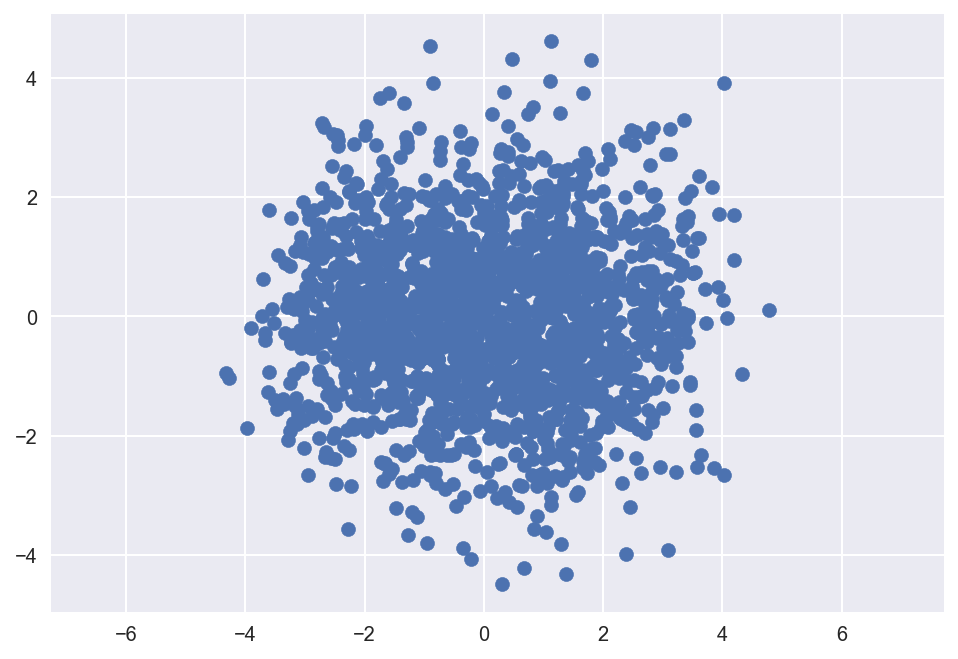

In [8]:
plt.scatter(drug_data_normalized_pca2d[:, 0], drug_data_normalized_pca2d[:, 1])
plt.axis('equal')

This PCA plot doesn't look great.

## Dimensionality reduction with t-SNE

Next, I apply t-SNE. Note that the code is nearly identical to using PCA: we import the nonlinear dimensionality reduction method we want to use (`TSNE`), create an instance of it (which we name `tsne`), and for that particular instance, we do `fit_transform` on the data. **Warning:** t-SNE takes way longer to run than PCA.

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)  # note: in practice you should actually play with the perplexity, learning rate, and number of iterations
drug_data_normalized_tsne2d = tsne.fit_transform(drug_data_normalized)

/home/mikec/Desktop/GithubCloud/UDA_demo/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mikec/Desktop/GithubCloud/UDA_demo/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Plotting is done just like before, except now we use our newly defined variable `drug_data_normalized_tsne2d`:

(-56.11857242584229, 50.7489091873169, -60.6687406539917, 64.3798345565796)

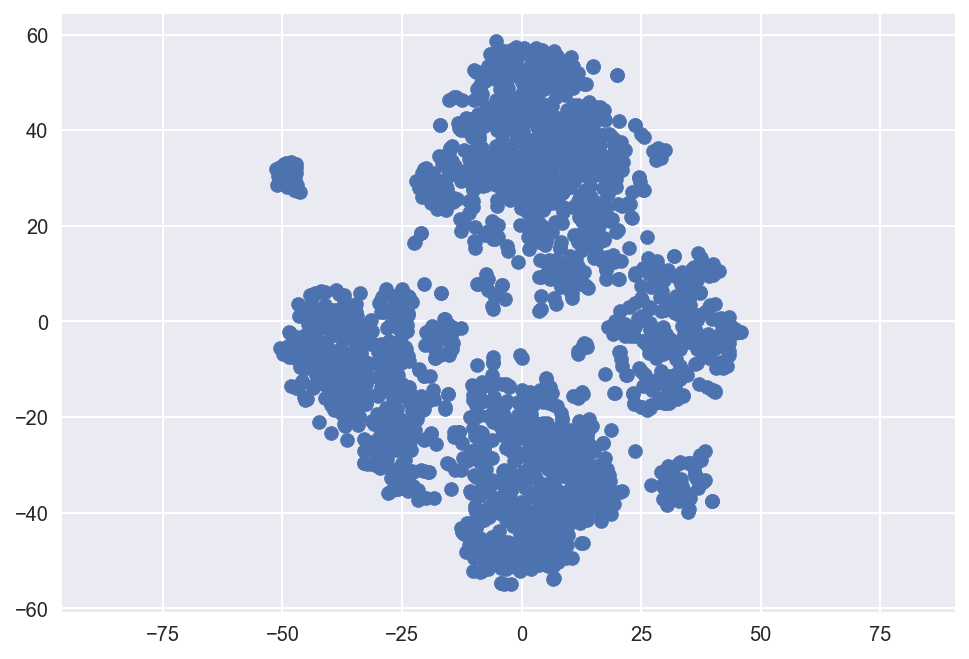

In [10]:
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1])
plt.axis('equal')

Unlike in PCA, in general for nonlinear dimensionality reduction methods, the axes aren't as easy to interpret. Each axis here is no longer just a simple weighted combination of the original features. In terms of interpretation, the main thing here is that points close to each other are more similar, and points far away from each other are more dissimilar.


However, with t-SNE, we are able to get some distinct blobs that appear. Could these blobs be semantically interesting? Possibly! (And possibly not!) Let's try to figure out what these clusters are...

## Clustering using k-means

From the visualization above, it looks like there are maybe something like 6 clusters (small ones in the top left and bottom right, and then four bigger clusters in the middle). Let's try k-means with k=6...

**WARNING:** In practice, you should usually try clustering in the original high-dimensional space first. Remember that reducing dimensionality typically results in some sort of information loss. Here, we intentionally cluster on the low-dimensional t-SNE representation as it's easier to visualize and explain the material.

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, n_init=1000, random_state=0)# Create instance, guess 6 cluseters, 1000 random steps
kmeans.fit(drug_data_normalized_tsne2d)# fit data

We can look at the cluster centers and the cluster assignments.

In [ ]:
kmeans.cluster_centers_  # cluster centers

array([[-37.68046  ,   3.2546716],
       [ 12.944503 ,  25.906467 ],
       [  5.8359265, -33.64501  ],
       [ -2.570379 ,  40.595085 ],
       [-20.978033 , -16.723228 ],
       [ 30.111925 ,  -4.392136 ]], dtype=float32)

In [ ]:
kmeans.labels_  # cluster assignments

array([1, 4, 0, ..., 5, 5, 2], dtype=int32)

In [ ]:
kmeans_cluster_assignments = kmeans.labels_

# alternatively, we can do:
# kmeans_cluster_assignments = kmeans.predict(drug_data_normalized_tsne2d)

(-57.40638885270168, 48.66960296402979, -59.19674732413162, 65.38699390616287)

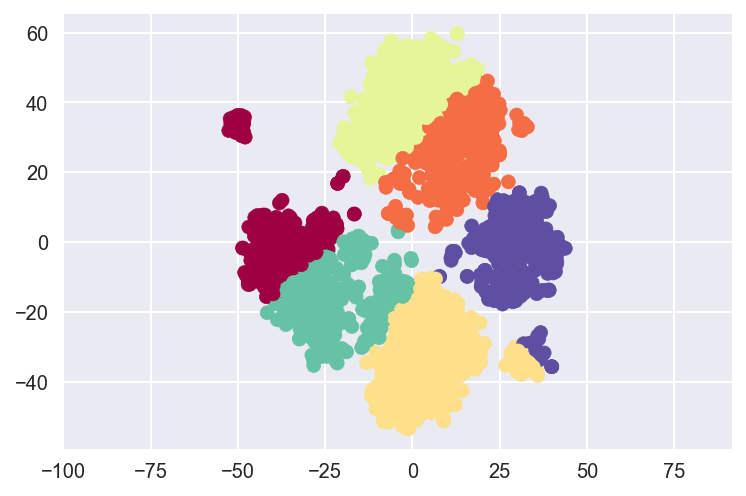

In [ ]:
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1],
            c=kmeans_cluster_assignments, cmap='Spectral')
# - `c` specifies how the different points should be colored (here, I set it to the
#   cluster assignments so different clusters get different colors)
plt.axis('equal')

These clusters don't look very good (which shouldn't be surprising--think about when k-means is expected to work well). In particular, the middle four blobs get cut up and assigned to different clusters.

## Clustering using a Gaussian mixture model (GMM)

Let's instead cluster using a GMM. A GMM is going to be in some sense more general than what a k-means "model" can capture. The fitting code is almost the same as in k-means.

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, n_init=1000, random_state=0)
gmm.fit(drug_data_normalized_tsne2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1000,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

We can examine the cluster probabilities (the pi's in the lecture slides) and the cluster centers (the mu's in the lecture slides). Note that these are not ordered in any particular way.

In [ ]:
gmm.weights_  # cluster probabilities Pis

array([0.22765205, 0.12685717, 0.35496044, 0.23369254, 0.01749777,
       0.03934004])

In [ ]:
gmm.means_  # cluster centers Means

array([[-29.87697782,  -9.76658205],
       [ 30.10271653,  -1.98717884],
       [  4.35871537,  33.62918151],
       [  2.02132799, -31.05967561],
       [-49.839568  ,  33.62406534],
       [ 28.15392859, -32.44633095]])

Some times it's helpful to quickly check the cluster sizes by printing out the cluster probabilities in decreasing order. For instance, we can quickly see if there are tiny clusters (which would appear with small probabilities).

In [ ]:
np.sort(gmm.weights_)[::-1]# to check tiny clusters, which could be outliners

array([0.35496044, 0.23369254, 0.22765205, 0.12685717, 0.03934004,
       0.01749777])

Finally, we plot the GMM clusters:

(-57.40638885270168, 48.66960296402979, -59.19674732413162, 65.38699390616287)

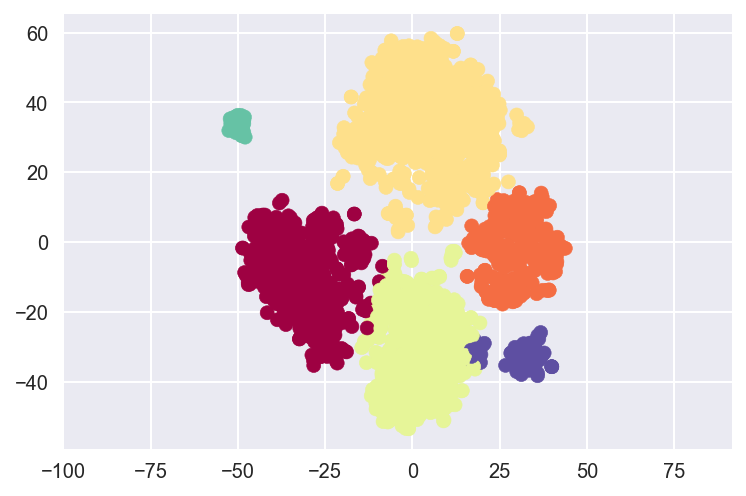

In [ ]:
gmm_cluster_assignments = gmm.predict(drug_data_normalized_tsne2d)
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1],
            c=gmm_cluster_assignments, cmap='Spectral')
plt.axis('equal')